In [1]:
import pandas as pd
import nltk as nltk
from nltk.corpus import stopwords
import numpy as np
from pathlib import Path
import itertools as it

import matplotlib.pyplot as plt

import src.similarity as  sim
import src.viz as viz 

[nltk_data] Downloading package punkt to /home/prf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/prf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/prf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In questa esercitazione effettuaremo una valutazione quantitativà per verificare la difficoltà di definizione di un concetto.

Nello specifico valuteremo la difficoltà alttraverso la **variabilità lessicale** presente nelle varie definizioni. Le definizioni sono state create da **20 annotari umani**.

### Data Loading

Come primo step carichiamo il file di annotazioni fornito.

In [2]:
defs_df = pd.read_csv(Path("data/definitions.csv"), sep=";")

# extract elements from level#1_level#2_concept col names
old_col_names = defs_df.columns
new_col_names = ["_".join(name.split("_")[0:2]) for name in old_col_names] 
concept_names = [name.split("_")[-1] for name in old_col_names]

defs_df.columns = new_col_names

Visualizziamo le prime 10 definizioni per i 4 concetti presenti:
* *Building* (concreto-generico)
* *Molecule* (concreto-specifico)
* *Freedom* (astratto-generico)
* *Compassion* (astratto-specifico)

In [3]:
defs_df.head(10)

,concreto_generico,concreto_specifico,astratto_generico,astratto_specifico
0,concrete structure typically made with cement,A chemistry term that describes the smallest p...,unconditional choice,comprehension
1,structure that hasa walls and roof,group of atoms,without constrains,be sensitive and understandable towards a person
2,"Human artifact dedicated to various purposes, ...",Chemical component formed by combinations of a...,The lack of physical or mental constraints.,The ability to experience other people's negat...
3,a construction where you can live inside,"set of atoms, that is components of which ever...","live without constrains, a state of mind",sympathetic attitude
4,structure where people can stay,"invisible thing , everything is made of it",conceptual idea where no one can limitate othe...,undterstand the suffering and feel sad for it
5,A construction made for living or decorative p...,a specific element that composes things,possibility to make decisions,sad feeling towards someone
6,Architectural structure with one or more level...,One of the smallest sub-structures of matter; ...,The ability of one to make free choices and ac...,The ability of one to make free choices and ac...
7,object built with material,invisible particle,autonomy to do something,understanding a bad situation
8,An architectural structure,Amount of substance,a state of autonomy,Understand the mood of others
9,a structure consisting of walls and foundation...,the smallest amount of matter,"possibility to move, think independently",understand a bad situation and take action to ...


Per portare a termine il task necessitiamo dunque di valutare la **similarità** delle differenti definizioni per ciascun concetto. La pipeline si articola nei seguenti step principali:

1. Scelta della rappresentazione computazionale delle definizioni
2. Preprocessing
3. Calcolo della **similarità media** tra tutte le possibili **combinazioni di coppie** di definizioni
4. Visualizzazione dei risultati

Seguendo la pipeline appena descritta, verranno utilizzate due modelli di rappresentazione differenti:
* **Bag-of-words** e funzione di similarità basata su overlap
* **Vector Space Model** e cosine similarity

### Rappresentazione Bag-of-Words
Rappresentazione naive nel quale vengono eliminate le informazioni sulla **costruzione sintattica** delle frasi e mantenute solo informazioni sull'occorrenza dei termini.

$$ \operatorname{sim}(D_1, D_2) = \frac{|d_1 \cap d_2|}{\min(|d_1|, |d_2|)} $$

dove $D_1, D_2$ rappresentano rispettivamente due definizioni secondo il modello bag-of-word, ovvero sono insiemi di token.

Vediamo un'esempio su una singola definizione.

In [11]:
concept_definition = defs_df['concreto_generico'].sample().values[0]
bow = sim.preprocess(concept_definition)
print(f"Definition: {concept_definition}\nBOW: {bow}")


Definition: architectural structure made by human
BOW: {'architectural', 'made', 'human', 'structure'}


Dalla rappresentazione BOW possiamo calcolare il valore di similarità. Vediamo un esempio su due definizioni campionate casualmente

In [16]:
definitions = defs_df['concreto_generico'].sample(2).values

bow1 = sim.preprocess(definitions[0])
bow2 = sim.preprocess(definitions[1])

sim_score = sim.overlap_similarity(bow1, bow2)

print(f"BOW Definitions:\n\nBOW def. #1: {bow1}\nBOW def. #2: {bow2}\n\nSimilarity score:{sim_score}")


BOW Definitions:

BOW def. #1: {'brick', 'made', 'structure', 'wall'}
BOW def. #2: {'architectural', 'made', 'section', 'people', 'host', 'one', 'material', 'floor', 'underground', 'and/or', 'various', 'used', 'object', 'structure', 'level'}

Similarity score:0.5


Dato che abbiamo molteplici definizioni si necessità calcolare differenti valori di similarità tra tutte le possibili definizioni dello stesso concetto e successivamente aggregarle. In questo caso viene scelta la media aritmetica come statistica di aggregazione.

In [6]:
bow_avg_scores_dict, bow_avg_scores = sim.concept_matrix_similarity(defs_df, sim.preprocess, sim.overlap_similarity)

bow_avg_scores_dict

{'concreto_generico': 0.2641743247006405,
 'concreto_specifico': 0.16257309941520467,
 'astratto_generico': 0.08401559454191034,
 'astratto_specifico': 0.08469785575048734}

### Vector Space Model
In questo caso, utilizzando una rappresentazione vettoriale, una definizione viene rappresentata in un vettore numerico.

Data la scarsità di dati, si è preferito costruire una matrice *term-document* costituita dalle **frequenze assolute** delle ccorrenze dei termi all'interno dei documenti (le definizioni). La matrice viene costruita dalla classe `CountVectorizer`.

Avendo a disposizione una rapppresentazione vettoriale, possiamo calcolare la similarità tra le definizioni utilizzando la **cosine similarity**:

$$ \operatorname{sim}(\mathbf{d_1}, \mathbf{d_2}) = \frac{\mathbf{d_1}\cdot\mathbf{d_2}}{||\mathbf{d_1}||||\mathbf{d_2}||} $$

dove $\mathbf{d_1}, \mathbf{d_2}$ rappresentano rispettivamente due definizioni secondo il modello vettoriale.

Vediamo un esempio. Il codice di seguito è a puro scopo dimostrativo, la stessa logica viene implementata nei metodi `similarity.vsm_preprocess` e `similairity.concept_matrix_similarity_vsm`


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(defs_df['concreto_generico'])

print(f"Vector space feature:\n{vectorizer.get_feature_names()}\n\nTerm-Document matrix:\n{X.toarray()}")

Vector space feature:
['aimed', 'architectural', 'artifact', 'bricks', 'built', 'cement', 'concrete', 'consisting', 'construction', 'contains', 'decorative', 'dedicated', 'different', 'doors', 'enclosed', 'floors', 'foundations', 'hasa', 'host', 'human', 'including', 'inside', 'levels', 'live', 'living', 'material', 'materials', 'multiple', 'object', 'objects', 'outside', 'palace', 'people', 'physical', 'purposes', 'roof', 'sections', 'sheltering', 'stay', 'strong', 'structure', 'typically', 'underground', 'used', 'usually', 'various', 'walls', 'ways', 'windows', 'world']

Term-Document matrix:
[[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
  0 1 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0

Come si può facilmente osservare lo spazio vettoriale generato dallo span della matrice è notevolmente **sparso**.

Di seguito valutiamo la similarità tra le definizioni di tutti e 4 i concetti:




In [8]:
vsm_avg_scores_dict, vsm_avg_scores = sim.concept_matrix_similarity_vsm(defs_df.copy(), sim.vsm_preprocess, sim.cosine_similarity)

vsm_avg_scores_dict


{'concreto_generico': 0.18829939289815426,
 'concreto_specifico': 0.08760498472448068,
 'astratto_generico': 0.06341399699136417,
 'astratto_specifico': 0.06817438103895451}

### Visualizzazione

Visualizziamo i risultati ottenuti

viz.plot_concept_matrix(avg_scores, axes[1], "avg similarity with cosine similarity")

[[0.26417432 0.1625731 ]
 [0.08401559 0.08469786]]
[[0.18829939 0.08760498]
 [0.063414   0.06817438]]


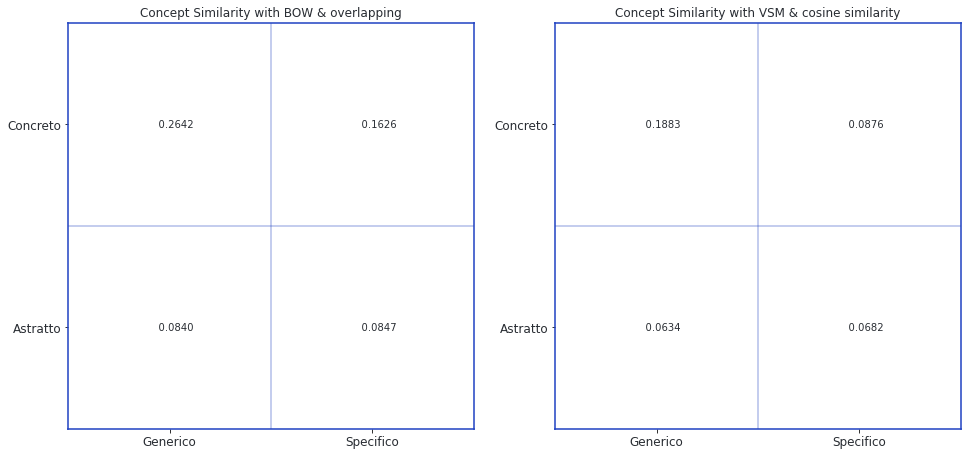

In [9]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

viz.plot_concept_matrix(bow_avg_scores, axes[0], "Concept Similarity with BOW & overlapping")
viz.plot_concept_matrix(vsm_avg_scores, axes[1], "Concept Similarity with VSM & cosine similarity")

## Risultati

Dall'analisi dei due plot emergono due importanti dinamiche sui risultati ottenuti:

* I valori di similarità **diminuiscono nettamente** passando dal concetto concreto rispetto a quello astratto. Altrettanto non si può dire passando dal concetto generico a quello specifico, in cui la similarità media si riduce meno drasticamente.

* I valori di similarità nel secondo caso con l'utilizzo del VSM si riducono sensibilmente. Da un'analisi della matrice terms-document, emerge che lo spazio costruito sia **altamente sparso** dato un numero così ridotto di campioni. Questo sicuramente influisce negativamente sui valori di similarità ottenuti.

Particolare attenzione bisogna porre alla generalizzazione di questi risultati, in quanto l'intera analisi è stata svolta su un campione di ridotte dimensione, tale da non essere statiticamente rilevante!

Inoltre si vuole evidenziare che entrambi gli approcci utilizzati sono di tipo statistico-distribuzionale e non prendono in considerazione in nessun modo la semantica espressa nelle definizioni. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=afb22156-bb61-4d65-847d-18db79c0d4d2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>